In [3]:
#!pip3 install open3d

In [3]:
from math import *
import open3d
import numpy as np
import matplotlib.pyplot as plt

In [4]:
a, b, c = 1, 1, 0.5

In [74]:
# These are some convenient functions to create open3d geometries and plot them
# The viewing direction is fine-tuned for this problem, you should not change them
vis = open3d.visualization.Visualizer()
vis.create_window(visible = False)

def draw_geometries(geoms):
    for g in geoms:
        vis.add_geometry(g)
    view_ctl = vis.get_view_control()
    view_ctl.set_up((0, 1e-4, 1))
    view_ctl.set_front((0, 0.5, 2))
    view_ctl.set_lookat((0, 0, 0))
    # do not change this view point
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(True)
    plt.figure(figsize=(8,6))
    plt.imshow(np.asarray(img)[::-1, ::-1])
    for g in geoms:
        vis.remove_geometry(g)

def create_arrow_from_vector(origin, vector):
    '''
    origin: origin of the arrow
    vector: direction of the arrow
    '''
    v = np.array(vector)
    v /= np.linalg.norm(v)
    z = np.array([0,0,1])
    angle = np.arccos(z@v)
    
    arrow = open3d.geometry.TriangleMesh.create_arrow(cylinder_radius=0.025, cone_radius=0.07, cylinder_height=0.25, 
                                                      cone_height=0.2)
    arrow.paint_uniform_color([1,0,1])
    T = np.eye(4)
    T[:3, 3] = np.array(origin)
    T[:3,:3] = open3d.geometry.get_rotation_matrix_from_axis_angle(np.cross(z, v) * angle)
    arrow.transform(T)
    return arrow

def create_ellipsoid(a,b,c):
    sphere = open3d.geometry.TriangleMesh.create_sphere()
    sphere.transform(np.diag([a,b,c,1]))
    sphere.compute_vertex_normals()
    return sphere


def create_lines(points):
    lines = []
    for p1, p2 in zip(points[:-1], points[1:]):
        height = np.linalg.norm(p2-p1)
        center = (p1+p2) / 2
        d = p2-p1
        d /= np.linalg.norm(d)
        axis = np.cross(np.array([0,0,1]), d)
        axis /= np.linalg.norm(axis)
        angle = np.arccos(np.array([0,0,1]) @ d)
        R = open3d.geometry.get_rotation_matrix_from_axis_angle(axis * angle)
        
        T = np.eye(4)
        T[:3,:3]=R
        T[:3,3] = center
        cylinder = open3d.geometry.TriangleMesh.create_cylinder(0.02, height)
        cylinder.transform(T)
        cylinder.paint_uniform_color([1,0,0])
        lines.append(cylinder)
    return lines

WARNING - 2022-10-23 20:09:28,994 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


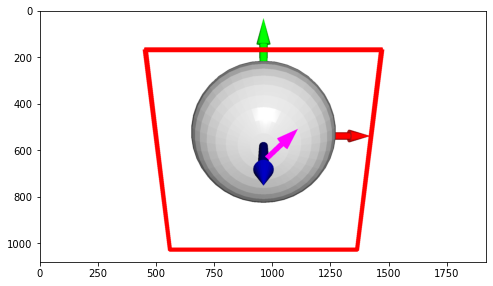

In [75]:
# exapmle code to draw ellipsoid, curve, and arrows
ellipsoid = create_ellipsoid(a, b, c)
cf = open3d.geometry.TriangleMesh.create_coordinate_frame()
cf.scale(1.5, (0,0,0))

arrow = create_arrow_from_vector([0.,0.,1.], [1.,1.,0.])
rectangular_curve = create_lines(np.array([[1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1], [1,1,1]], dtype=np.float64))
draw_geometries([ellipsoid, cf, arrow] + rectangular_curve)

In [76]:
def compute_Fp(p):
    u, v = p
    fuv = [a * cos(u) * sin(v), 
           b * sin(u) * sin(v), 
           c * cos(v)
          ]
    
    return fuv

In [77]:
def compute_GammaT(p, v, t):
    return v * t + p

In [78]:
def compute_FofGammaT(p, v, t):
    gammaT = compute_GammaT(p, v, t)
    FofGammaT = [a * cos(gammaT[0]) * sin(gammaT[1]), 
           b * sin(gammaT[0]) * sin(gammaT[1]), 
           c * cos(gammaT[1])
           ]
    
    return FofGammaT

In [79]:
def compute_FofGammaDashT(p, v, t):
    gammaT = compute_GammaT(p, v, t)
    
    FofGammaDashT = [-a * v[0] * sin(gammaT[0]) * sin(gammaT[1]) + a * v[1] * cos(gammaT[0]) * cos(gammaT[1]), 
                     b * v[0] * cos(gammaT[0]) * sin(gammaT[1]) + b * v[1] * sin(gammaT[0]) * cos(gammaT[1]), 
                     -c * v[1] * sin(gammaT[1])
                    ]
    return FofGammaDashT

### 2.1 Plot $f(\gamma(t))$ and $f^{'}(\gamma(0))$ on the surface of the ellipsoid in $\mathbb{R}^3$ for $p = [1, 1]$ and $v = [1,1]$
- Red curve represents $f(\gamma(t))$
- Pink/Magenta arrow represents $f^{'}(\gamma(0))$

In [80]:
def show_points(points):
    fig = plt.figure(figsize=(10,6))
    ax = fig.gca(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[0], points[2], points[1])

WARNING - 2022-10-23 20:09:43,889 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


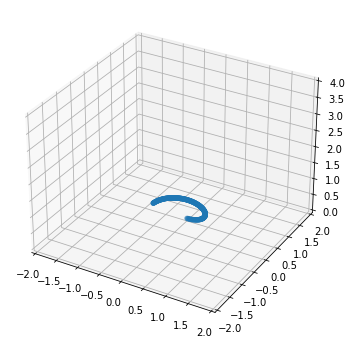

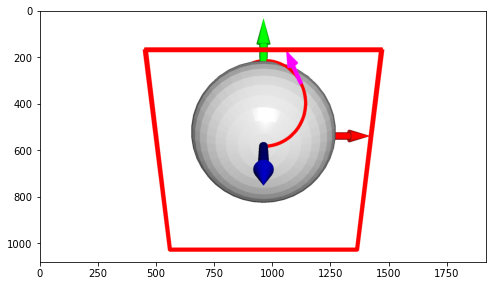

In [81]:
p = np.array([1.0, 1.0])
v = np.array([1.0, 1.0])

FofGammaT_pts = []

t_range = np.arange(-1, 1.00001, 0.01)
for t in t_range:
    FofGammaT = compute_FofGammaT(p, v, t)
    FofGammaT_pts.append(FofGammaT)

FofGammaT_pts = np.array(FofGammaT_pts)

show_points(FofGammaT_pts.T)

arrow = create_arrow_from_vector([cos(1)*sin(1), sin(1)*sin(1), 0.5*cos(1)], [cos(2), sin(2), -0.5*sin(1)])
curve_FofGammaT = create_lines(FofGammaT_pts)
rectangle_curve = create_lines(np.array([[1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1], [1,1,1]], dtype=np.float64))
draw_geometries([ellipsoid, cf, arrow] + curve_FofGammaT + rectangle_curve)

### 2.2 Let $p = [\pi/4, \pi/6]$ and $v = [1,0]$. Draw the curve of $f(\gamma(t))$ on the surface of the ellipsoid.

WARNING - 2022-10-23 20:09:48,512 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


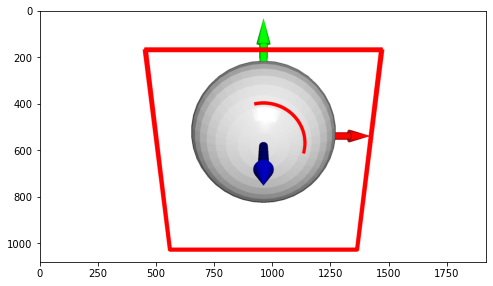

In [82]:
p = np.array([pi/4, pi/6])
v = np.array([1.0, 0])
t_range = np.arange(-1, 1.00001, 0.01)
# print(t_range)

# draw the curve of (f o \gamma)(t) on ellipsoid surface
curve_pts = []

for t in t_range:
    FofGammaT = compute_FofGammaT(p, v, t)
    curve_pts.append(FofGammaT)

curve_pts = np.array(curve_pts)
# print(curve_pts.shape)

rectangle_curve = create_lines(np.array([[1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1], [1,1,1]], dtype=np.float64))
curve_FofGammaT = create_lines(curve_pts)
draw_geometries([ellipsoid, cf] + curve_FofGammaT + rectangle_curve)

### 2.3 (c) Draw $Df_p(v)$ on the ellipsoid when $p = [\pi/4, \pi/6]$ and $v = [1,0]$

WARNING - 2022-10-23 20:09:52,707 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


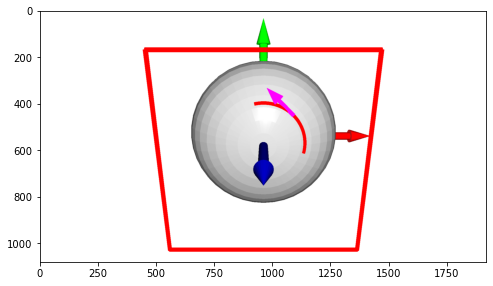

In [83]:
p = np.array([pi/4, pi/6])
v = np.array([1.0, 0])

fp = compute_Fp(p)
Dfpv = compute_FofGammaDashT(p, v, t=0)
# print(Dfpv)

rectangle_curve = create_lines(np.array([[1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1], [1,1,1]], dtype=np.float64))
arrow = create_arrow_from_vector(origin=fp, vector=Dfpv)
draw_geometries([ellipsoid, cf, arrow] + curve_FofGammaT + rectangle_curve)

### 2.3 (e) Give an orthonormal bases of the tangent space at $f(p)$ when $p = [\pi/4, \pi/6]$. Draw the orthonormal bases on the ellipsoid

In [84]:
def compute_dfdu_dfdv(p):
    u, v = p
    dfdu = [-a * sin(u) * sin(v), b * cos(u) * sin(v), 0]
    dfdv = [a * cos(u) * cos(v), b * sin(u) * cos(v), -c * sin(v)]
    
    return dfdu, dfdv

WARNING - 2022-10-23 20:12:10,334 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Orthonormal basis vectors: 
 v1: [-0.70710678  0.70710678  0.        ] 
 v2: [ 0.67936622  0.67936622 -0.2773501 ] 

Magnitude |v1|= 1.0 Magnitude |v2|= 1.0
Dot product (v1.v2) = 0.0


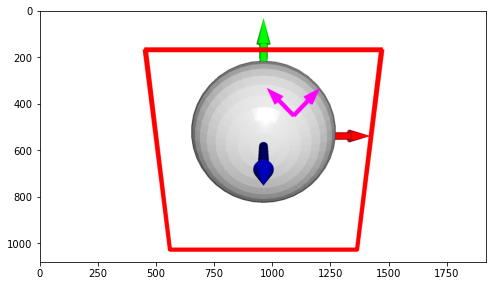

In [85]:
p = np.array([pi/4, pi/6])

fp = compute_Fp(p)
dfdu, dfdv = compute_dfdu_dfdv(p)

dfdu_mag = np.linalg.norm(dfdu)
dfdv_mag = np.linalg.norm(dfdv)

dfdu_hat = dfdu / dfdu_mag
dfdv_hat = dfdv / dfdv_mag

print("Orthonormal basis vectors: \n", "v1:", dfdu_hat, "\n", "v2:", dfdv_hat, "\n")
print("Magnitude |v1|=", np.linalg.norm(dfdu_hat), "Magnitude |v2|=", np.linalg.norm(dfdv_hat))
print("Dot product (v1.v2) =", np.dot(dfdu_hat, dfdv_hat))

rectangle_curve = create_lines(np.array([[1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1], [1,1,1]], dtype=np.float64))
arrow1 = create_arrow_from_vector(origin=fp, vector=dfdu_hat)
arrow2 = create_arrow_from_vector(origin=fp, vector=dfdv_hat)
draw_geometries([ellipsoid, cf, arrow1, arrow2] + rectangle_curve)

### 2.5 (c) Draw the two principal curvature directions in the tangent plane of the ellipsoid $p = [\frac{\pi}{4}, \frac{\pi}{6}]$

WARNING - 2022-10-23 20:12:13,089 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dot product between two principal curvature directions: 0.0


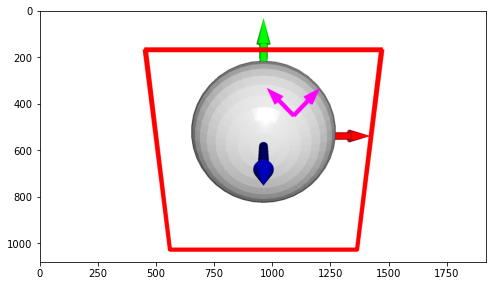

In [86]:
# eigenvector of the shape operator
eigenvec1 = np.array([1.0, 0])
eigenvec2 = np.array([0, 1.0])

p = np.array([pi/4, pi/6])
fp = compute_Fp(p)

dfdu, dfdv = compute_dfdu_dfdv(p)
Dfp_mat = np.array([dfdu, dfdv]).T   # (3,2)

prin_curv_dir1 = np.matmul(Dfp_mat, eigenvec1)
prin_curv_dir1 = prin_curv_dir1 / np.linalg.norm(prin_curv_dir1)
prin_curv_dir2 = np.matmul(Dfp_mat, eigenvec2)
prin_curv_dir2 = prin_curv_dir2 / np.linalg.norm(prin_curv_dir2)

print("Dot product between two principal curvature directions:", np.dot(prin_curv_dir1, prin_curv_dir2))

rectangle_curve = create_lines(np.array([[1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1], [1,1,1]], dtype=np.float64))
arrow1 = create_arrow_from_vector(origin=fp, vector=prin_curv_dir1)
arrow2 = create_arrow_from_vector(origin=fp, vector=prin_curv_dir2)
draw_geometries([ellipsoid, cf, arrow1, arrow2] + rectangle_curve)